In [1]:
import latent_space
from PIL import Image
import numpy as np
import output
from histology_main import get_session,close_session
from constants import FULL_OUTPUT_PATH, BASE_PATH, BATCH_SIZE, Z_NOISE_DIM
import tensorflow as tf
import matplotlib.pylab as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from os import listdir, remove
import random
from glob import glob
%matplotlib inline
import dcgan_alt as dcgan
from utils import change_active_config
from evaluation import load_graph, read_tensor_from_image_file, load_labels

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
def label_and_show(src_dir, model_file, labels_file, input_height = 299,input_width = 299, image_list=None, show=0):

    input_mean = 0
    input_std = 255
    input_layer = "Placeholder"
    output_layer = "final_result"

    files_to_show=[]
    
    if image_list:
        [files_to_show.append(src_dir+"/"+file) for file in image_list]
    else:
        files = [os.path.join(src_dir, file) for file in listdir(src_dir)]
        files_to_show = random.sample(files,show)
        
    graph = load_graph(model_file)
    fig = plt.figure(figsize=(30,20))
    
    for i,f in enumerate(files_to_show):
        t = read_tensor_from_image_file(
              f,
              input_height=input_height,
              input_width=input_width,
              input_mean=input_mean,
              input_std=input_std)

        input_name = "import/" + input_layer
        output_name = "import/" + output_layer
        input_operation = graph.get_operation_by_name(input_name)
        output_operation = graph.get_operation_by_name(output_name)

        with tf.Session(graph=graph) as sess:
            results = sess.run(output_operation.outputs[0], {
                input_operation.outputs[0]: t
            })
        results = np.squeeze(results)
        predic = results.argsort()[::-1]
        labels = load_labels(labels_file)
        
        subplt=fig.add_subplot(np.sqrt(show), np.sqrt(show) ,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        color="green" if (labels[predic[0]].startswith("ben") or labels[predic[0]].startswith("neg")) else "red" 
        subplt.set_xlabel(labels[predic[0]]+" "+str(results[predic[0]]),color=color).set_fontsize(20)
        name = f.split("/")[-1]
        color="green" if name.startswith("neg") else "red" if name.startswith("pos") else "blue"
        subplt.set_title(name,color=color).set_fontsize(22)
        image = imread(f)
        imshow(image)

# CelebA : Aritmetica de vectores conceptuales con imagenes histólogicas

In [3]:
dataset = "camelyon_17_16_level0"
change_active_config(dataset)

In [4]:
session, input_real, input_z = get_session(1)
z_batch_tensor = tf.random.uniform(
        (BATCH_SIZE, Z_NOISE_DIM), dtype=tf.float32, minval=-1, maxval=1)

INFO:tensorflow:Restoring parameters from /home/ruben/Master/camelyon_17_16_level0/checkpoints/model-85000
85000


In [21]:
prefix = "histo_"
#clean up
[os.remove(file) for file in glob(src_dir_test+"*"+prefix+"*.*")]
#Generamos unas 3000 imagenes (32*100)
output.generate_samples(session, z_batch_tensor, input_z, BATCH_SIZE * 100, save_tensor=True, name_prefix=prefix)

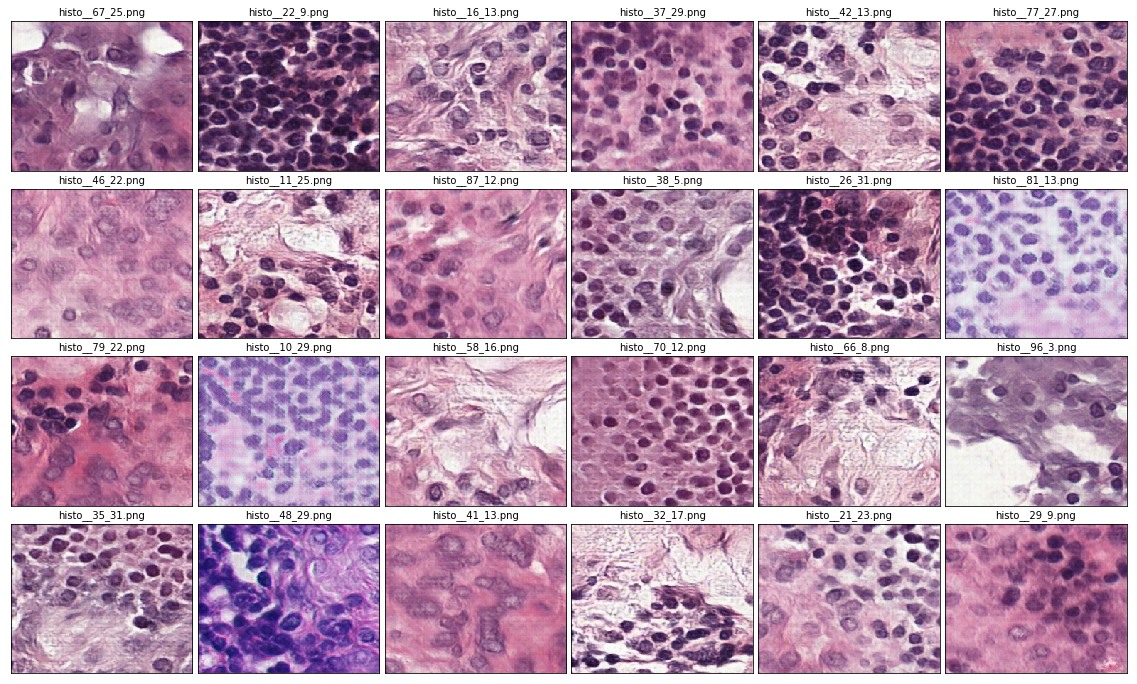

In [78]:
all_files = glob(src_dir_test+"*"+prefix+"*.png")
files_to_show = random.sample(all_files,24)
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.12, wspace=0.03)
for i,img_file in enumerate(files_to_show):
    img = plt.imread(img_file)
    plt.subplot(4, 6, i+1).set_title(img_file.split("/")[-1]).set_fontsize(10)
    plt.imshow(img, aspect="auto")
    plt.xticks([])
    plt.yticks([])
    i=i+1

Seleccionamos 3 imágenes que nos parezcan claramente negativas y en los que se vea la luz de estructuras tubulares, otras 3 que no contengan ninguna de estas estructuras y 3 más, cancerosas en este caso y también sin estructuras tubulares. Vamos a realizar la operacion 3 - 3 + 3 para obtener una imagen cancerosa con estructuras tubulares.

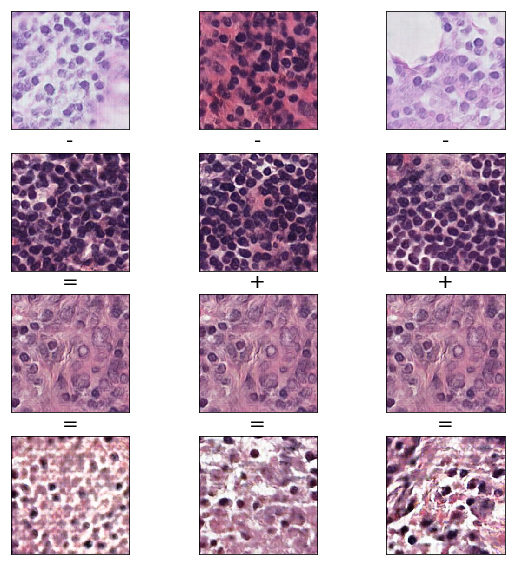

In [75]:
normal_tub_1 = np.loadtxt(FULL_OUTPUT_PATH + 'histo__57_19.txt')
normal_tub_2 = np.loadtxt(FULL_OUTPUT_PATH + 'histo__75_24.txt')
normal_tub_3 = np.loadtxt(FULL_OUTPUT_PATH + 'histo__21_7.txt')

normal_no_tub_1 = np.loadtxt(FULL_OUTPUT_PATH + 'histo__40_30.txt')
normal_no_tub_2 = np.loadtxt(FULL_OUTPUT_PATH + 'histo__9_3.txt')
normal_no_tub_3 = np.loadtxt(FULL_OUTPUT_PATH + 'histo__20_2.txt')

cancer_no_tub_1 = np.loadtxt(FULL_OUTPUT_PATH + 'histo__15_11.txt')
cancer_no_tub_2 = np.loadtxt(FULL_OUTPUT_PATH + 'histo__18_6.txt')
cancer_no_tub_3 = np.loadtxt(FULL_OUTPUT_PATH + 'histo__57_19.txt')

resultado_1 = normal_no_tub_1 - normal_tub_1 + cancer_no_tub_1
resultado_2 = normal_no_tub_2 - normal_tub_2 + cancer_no_tub_2
resultado_3 = normal_no_tub_3 - normal_tub_3 + cancer_no_tub_3


resultados = [normal_tub_1,normal_tub_2,normal_tub_3,
              normal_no_tub_1,normal_no_tub_2,normal_no_tub_3,
              cancer_no_tub_1,cancer_no_tub_1,cancer_no_tub_1,
              resultado_1,resultado_2,resultado_3]


plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.2, wspace=0.03)
for i,img in enumerate(resultados):
    img = np.expand_dims(img,0)
    z_ = tf.placeholder(tf.float32, [1, Z_NOISE_DIM])
    samples = session.run(dcgan.sampler(z_,1), feed_dict={z_: img})
    img = np.squeeze(samples)
    subplt = plt.subplot(4, 3, i+1)
    subplt.set_title("" if i<3 else "-" if (i>2 and i<6) else "+" if (i>6 and i<9) else "=").set_fontsize(20)
    plt.imshow(img / 2 + 0.5)
    plt.xticks([])
    plt.yticks([])


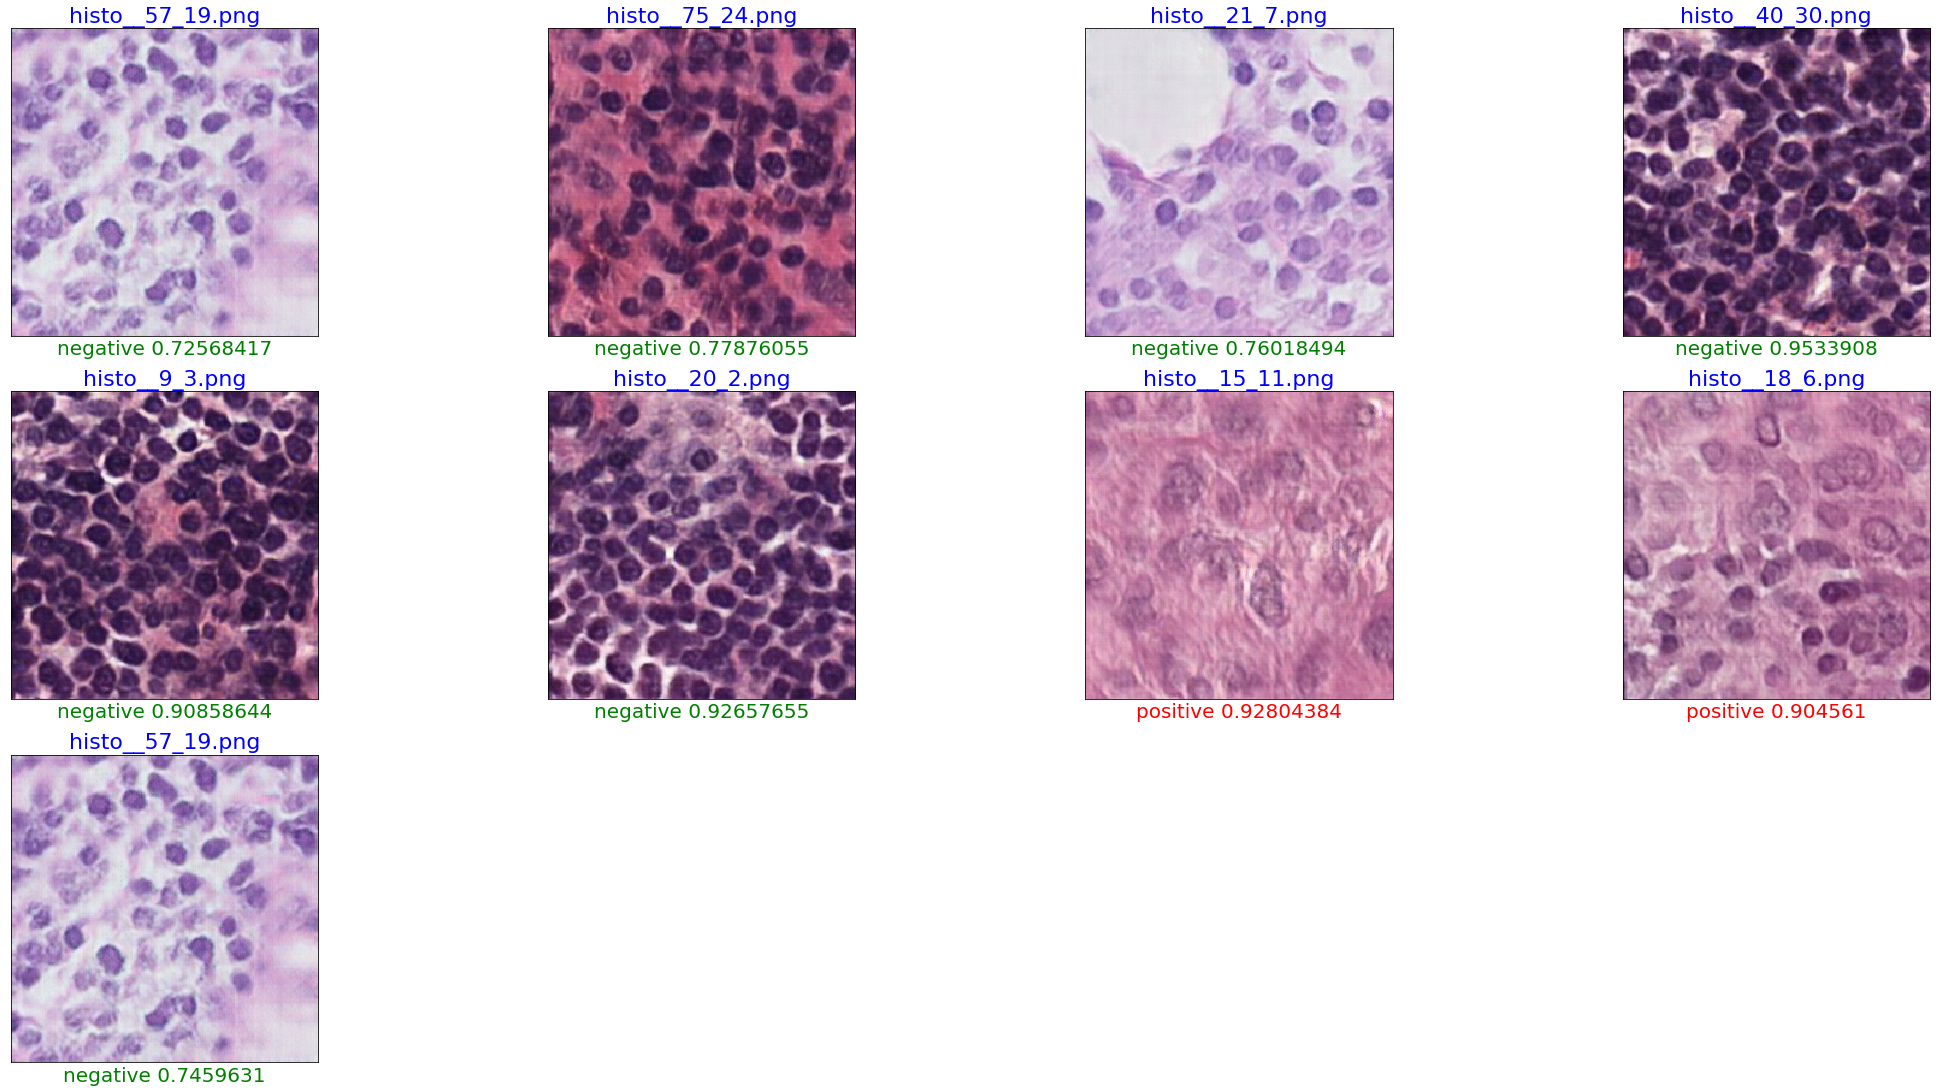

In [77]:
src_dir_test= FULL_OUTPUT_PATH
model="evaluation/trained_models/incp_v3_15k_l0_real.pb"
labels="evaluation/labels.txt"

list_to_show = ['histo__57_19.png','histo__75_24.png','histo__21_7.png','histo__40_30.png','histo__9_3.png','histo__20_2.png','histo__15_11.png','histo__18_6.png','histo__57_19.png']

label_and_show(src_dir_test, model, labels, image_list = list_to_show , show = 16)

Otro tipo de operacion que podemos realizar es elegir dos tensores y avanzar por la "linea" que los une en el espacio latente, creando asi una interpolacion suave de imagenes intermedias

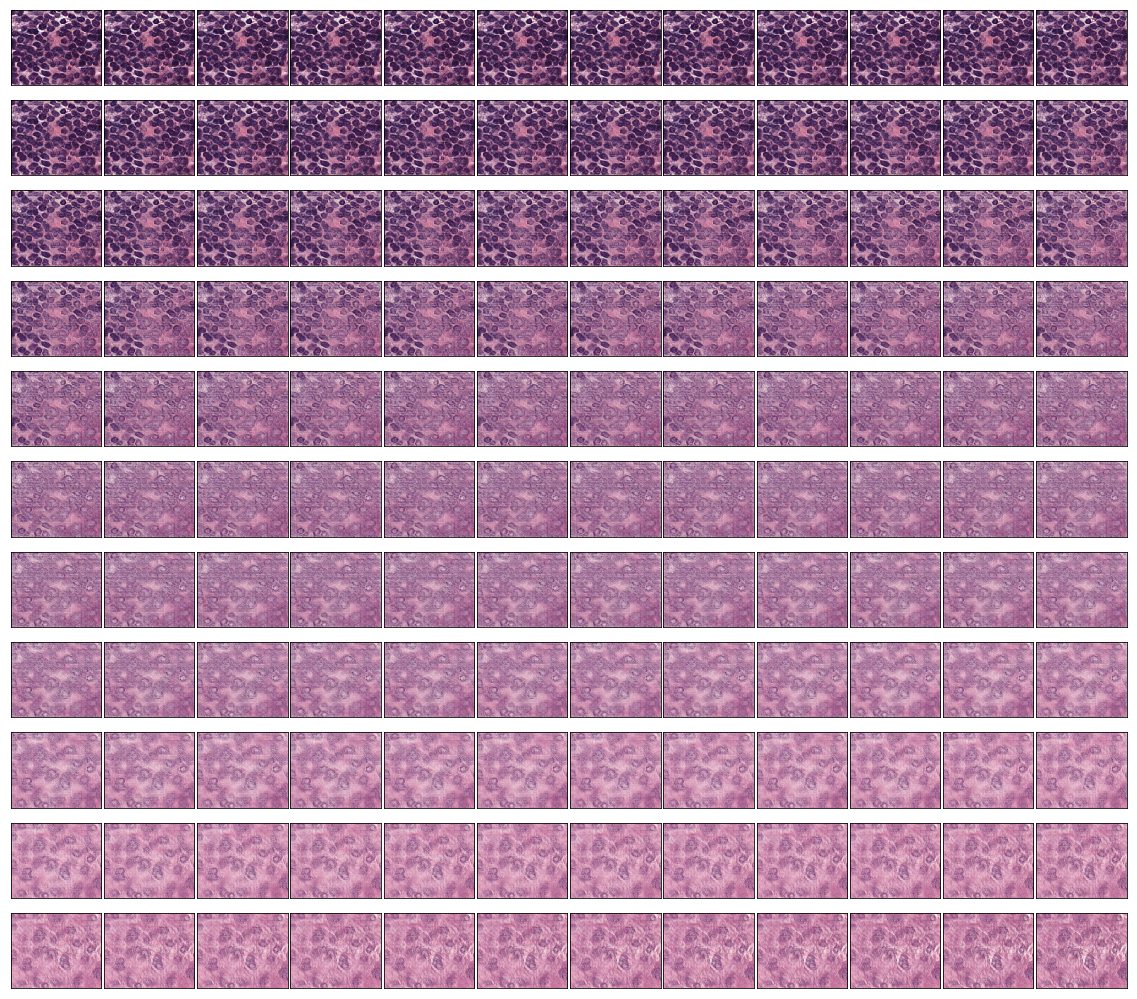

In [5]:
from utils import natural_keys

#clean up
[remove(file) for file in glob(FULL_OUTPUT_PATH+"*interp*.png")]
punto_a = np.loadtxt(FULL_OUTPUT_PATH + 'histo__9_3.txt')
punto_b = np.loadtxt(FULL_OUTPUT_PATH + 'histo__15_11.txt')
latent_space.interpolate(session, punto_a, punto_b, 132)

all_files = glob(FULL_OUTPUT_PATH+"*interp*")
all_files.sort(key=natural_keys)
plt.figure(figsize=(20, 18))
plt.subplots_adjust(hspace=0.2, wspace=0.03)
for i,img in enumerate(all_files):
    img = plt.imread(img)
    plt.subplot(11, 12, i+1)
    plt.imshow(img, aspect="auto")
    plt.xticks([])
    plt.yticks([])


In [6]:
import imageio
images = []
for filename in all_files:
    images.append(imageio.imread(filename))
imageio.mimsave('histo.gif', images)

![SegmentLocal](histo.gif "segment")

In [ ]:
close_session(sess)